In [1]:
import glacierml as gl
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import math
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from scipy.stats import gaussian_kde
import os
from scipy.stats import norm
import statsmodels.api as sm
from scipy.stats import kstest
from scipy.stats import shapiro 
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

2023-09-06 09:53:54.305611: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-06 09:53:54.350714: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 09:53:55.034365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
pr = 0.075
model = {}
model_history = {}
results = {}
normalizer = {}
y = {}
test_features = {}
test_labels = {}
train_features = {}
train_labels = {}
l1 = {}
l2 = {}
q75 = {}
q25 = {}
iqr = {}
gamma = {}
unc = {}
residuals = pd.DataFrame()
for i in (range(1,5,1)):
    m = str(i)


    df = gl.coregister_data(m)
    df = df.drop(['RGIId'],axis = 1)
#     df['Area'] = np.log(df['Area'])

#     if m == '4':
#         df = df.drop_duplicates(keep = False)
#         df = df.drop(df[df['Thickness'] >= 300].index)
#         df = df.drop(df[df['Thickness'] == 267].index)
#         df = df.drop(df[df['Thickness'] == df['Thickness'].min()].index)

    df = df.reset_index()
    df = df.drop('index', axis = 1)
    total_inputs = (len(df.columns)) * len(df)
    dp = pr * total_inputs
    tp = dp - (len(df.columns) + (len(df.columns)-1) )
    g = (len(df.columns) + (len(df.columns) - 1))
    l2[m] = 4
    l1[m] = int((dp - 1 - g - 2*l2[m]) / (10 + l2[m]))

    arch = str(l1[m]) + '-' + str(l2[m])

    svd_mod_pth = 'saved_models/singles_' + m + '/' + arch 
    svd_res_pth = 'saved_results/singles_' + m + '/'


    isdir = os.path.isdir(svd_mod_pth)
    if isdir == False:
        os.makedirs(svd_mod_pth)
    isdir = os.path.isdir(svd_res_pth)
    if isdir == False:
        os.makedirs(svd_res_pth)
    callback = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        min_delta = 0.001,
        patience = 10,
        verbose = 0,
        mode = 'auto',
        baseline = None,
        restore_best_weights = True
    )

    train_features[m], test_features[m], train_labels[m], test_labels[m] = gl.split_data(df)
    normalizer = preprocessing.Normalization(axis=-1)
    normalizer.adapt(np.array(train_features[m]))

    model[m] = gl.build_dnn_model(
        normalizer, learning_rate = 0.01, layer_1 = l1[m], layer_2 = l2[m],loss = 'mae'
    )

    model_history[m] = model[m].fit(
        train_features[m],
        train_labels[m],
        validation_split=0.2,
        callbacks = [callback],
        verbose=0, 
        epochs=500
    )

#     model[m].save(svd_mod_pth)
#     pd.DataFrame(model_history[m].history).to_pickle(svd_res_pth + '.pkl')

    total_params = model[m].count_params()
    print(f'parameters = {total_params}')


    trained_parameters = model[m].count_params() - (
        len(df.columns) + (len(df.columns) - 1)
    )
    print(f'trained parameters = {trained_parameters}')



#     cp = 9 + l1[m]*((len(df.columns))) + l2[m]*(l1[m]+1)
    cp = l1[m]*(9+1) + l2[m]*(l1[m]+1) + 1*(l2[m]+1) + g
    print(f'counted params = {cp}')

    total_inputs = len(df) *( len(df.columns)-1)
#     print(f'total inputs = {total_inputs})
    parameter_ratio = np.round(trained_parameters / total_inputs,3)
    print(f'parameter / input ratio = {parameter_ratio}')
    print(l1[m],l2[m])
#     print(trained_parameters)

    results[m] = model[m].evaluate(test_features[m], test_labels[m])
    y[m] = model[m].predict(test_features[m]).flatten()

    full_res = str(i + 10)
    y[full_res] =  (
        (model[m].predict(df.drop('Thickness',axis = 1)).flatten() - df['Thickness']) 
    )


    full_pred = str(i + 20)
    y[full_pred] = (model[m].predict(df.drop('Thickness',axis = 1)).flatten())

    p_res = str(i + 30)
    y[p_res] = (y[full_pred] - df['Thickness']) / df['Thickness']

    q75[p_res] = np.percentile(y[p_res], 75)
    q25[p_res] = np.percentile(y[p_res], 25)

    iqr[p_res] = q75[p_res] - q25[p_res]
    gamma[p_res] = iqr[p_res]

    unc[m] = gamma[p_res] * y[full_pred]

    ver_res = y[full_pred] - df['Thickness']
    ver_res_mean = np.mean(ver_res)
    ver_res_std =  np.std(ver_res)

    test_res = (y[m] - test_labels[m]) 

    tq75 = np.percentile(test_res,75)
    tq25 = np.percentile(test_res,25)
    TIQR = tq75 - tq25

    vq75 = np.percentile(ver_res,75)
    vq25 = np.percentile(ver_res,25)
    VIQR = vq75 - vq25

    test_res_m = pd.DataFrame(pd.Series(m,name = 'M'))
    test_res_mean = pd.DataFrame(pd.Series(test_res.mean(), name = 'Test Res'))
    test_res_std = pd.DataFrame(pd.Series(test_res.std(),name = 'Test STD'))



    test_res_mean = test_res_m.join(test_res_mean)
    test_res_mean = test_res_mean.join(test_res_std)
    test_res_mean['TRes Max'] = test_res.max()
    test_res_mean['TRes Min'] = test_res.min()
    test_res_mean['TRes IQR'] = TIQR
    test_res_mean['VRes Mean'] = ver_res_mean    
    test_res_mean['VRes STD'] = ver_res_std
    test_res_mean['VRes Max'] = ver_res.max()
    test_res_mean['VRes Min'] = ver_res.min()
    test_res_mean['VRes IQR'] = VIQR

    residuals = pd.concat([residuals,test_res_mean])
    print('')
res = pd.DataFrame(results,index = ['Loss']).T
res = res.reset_index()

residuals = residuals.reset_index()
residuals = pd.concat([res, residuals], axis = 1, ignore_index = False)
residuals = residuals.drop('index', axis = 1)
residuals = residuals.rename(columns = {'Loss':'MAE'})

cols = list(residuals.columns)
a, b = cols.index('MAE'), cols.index('M')
cols[b], cols[a] = cols[a], cols[b]
residuals = residuals[cols]

residuals.sort_values('MAE')

2023-09-06 09:53:57.223447: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


parameters = 364
trained parameters = 345
counted params = 364
parameter / input ratio = 0.077
24 4
16/16 [==============================] - 0s 667us/step



In [2]:
pr = 0.075
model = {}
model_history = {}
results = {}
normalizer = {}
y = {}
test_features = {}
test_labels = {}
train_features = {}
train_labels = {}
l1 = {}
l2 = {}
q75 = {}
q25 = {}
iqr = {}
gamma = {}
unc = {}
residuals = pd.DataFrame()
for i in (range(1,5,1)):
    m = str(i)

    
    df = gl.coregister_data(m)
    df = df.drop(['RGIId'],axis = 1)
#     df['Area'] = np.log(df['Area'])

#     if m == '4':
#         df = df.drop_duplicates(keep = False)
#         df = df.drop(df[df['Thickness'] >= 300].index)
#         df = df.drop(df[df['Thickness'] == 267].index)
#         df = df.drop(df[df['Thickness'] == df['Thickness'].min()].index)

    df = df.reset_index()
    df = df.drop('index', axis = 1)
    total_inputs = (len(df.columns)) * len(df)
    dp = pr * total_inputs
    tp = dp - (len(df.columns) + (len(df.columns)-1) )
    g = (len(df.columns) + (len(df.columns) - 1))
    l2[m] = 4
    l1[m] = int((dp - 1 - g - 2*l2[m]) / (10 + l2[m]))
    
    arch = str(l1[m]) + '-' + str(l2[m])

    svd_mod_pth = 'saved_models/singles_' + m + '/' + arch 
    svd_res_pth = 'saved_results/singles_' + m + '/'
    
    
    isdir = os.path.isdir(svd_mod_pth)
    if isdir == False:
        os.makedirs(svd_mod_pth)
    isdir = os.path.isdir(svd_res_pth)
    if isdir == False:
        os.makedirs(svd_res_pth)
    callback = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        min_delta = 0.001,
        patience = 10,
        verbose = 0,
        mode = 'auto',
        baseline = None,
        restore_best_weights = True
    )
    
    (
     train_features[m], test_features[m],
     train_labels[m], test_labels[m]
    ) = gl.split_data(df)
    normalizer = preprocessing.Normalization(axis=-1)
    normalizer.adapt(np.array(train_features[m]))

    model[m] = gl.build_dnn_model(
        normalizer, learning_rate = 0.01, layer_1 = l1[m], layer_2 = l2[m],loss = 'mae'
    )

    model_history[m] = model[m].fit(
        train_features[m],
        train_labels[m],
        validation_split=0.2,
        callbacks = [callback],
        verbose=0, 
        epochs=500
    )
    
#     model[m].save(svd_mod_pth)
#     pd.DataFrame(model_history[m].history).to_pickle(svd_res_pth + '.pkl')
    
    total_params = model[m].count_params()
    print(f'parameters = {total_params}')

    
    trained_parameters = model[m].count_params() - (
        len(df.columns) + (len(df.columns) - 1)
    )
    print(f'trained parameters = {trained_parameters}')
    


#     cp = 9 + l1[m]*((len(df.columns))) + l2[m]*(l1[m]+1)
    cp = l1[m]*(9+1) + l2[m]*(l1[m]+1) + 1*(l2[m]+1) + g
    print(f'counted params = {cp}')
    
    total_inputs = len(df) *( len(df.columns)-1)
#     print(f'total inputs = {total_inputs})
    parameter_ratio = np.round(trained_parameters / total_inputs,3)
    print(f'parameter / input ratio = {parameter_ratio}')
    print(l1[m],l2[m])
#     print(trained_parameters)
    
    results[m] = model[m].evaluate(test_features[m], test_labels[m])
    y[m] = model[m].predict(test_features[m]).flatten()
    
    full_res = str(i + 10)
    y[full_res] =  (
        (model[m].predict(df.drop('Thickness',axis = 1)).flatten() - df['Thickness']) 
    )
    
    
    full_pred = str(i + 20)
    y[full_pred] = (model[m].predict(df.drop('Thickness',axis = 1)).flatten())
    
    p_res = str(i + 30)
    y[p_res] = (y[full_pred] - df['Thickness']) / df['Thickness']

    q75[p_res] = np.percentile(y[p_res], 75)
    q25[p_res] = np.percentile(y[p_res], 25)

    iqr[p_res] = q75[p_res] - q25[p_res]
    gamma[p_res] = iqr[p_res]

    unc[m] = gamma[p_res] * y[full_pred]
    
    ver_res = y[full_pred] - df['Thickness']
    ver_res_mean = np.mean(ver_res)
    ver_res_std =  np.std(ver_res)
    
    test_res = (y[m] - test_labels[m]) 
    
    tq75 = np.percentile(test_res,75)
    tq25 = np.percentile(test_res,25)
    TIQR = tq75 - tq25
    
    vq75 = np.percentile(ver_res,75)
    vq25 = np.percentile(ver_res,25)
    VIQR = vq75 - vq25
    
    test_res_m = pd.DataFrame(pd.Series(m,name = 'M'))
    test_res_mean = pd.DataFrame(pd.Series(test_res.mean(), name = 'Test Res'))
    test_res_std = pd.DataFrame(pd.Series(test_res.std(),name = 'Test STD'))


    
    test_res_mean = test_res_m.join(test_res_mean)
    test_res_mean = test_res_mean.join(test_res_std)
    test_res_mean['TRes Max'] = test_res.max()
    test_res_mean['TRes Min'] = test_res.min()
    test_res_mean['TRes IQR'] = TIQR
    test_res_mean['VRes Mean'] = ver_res_mean    
    test_res_mean['VRes STD'] = ver_res_std
    test_res_mean['VRes Max'] = ver_res.max()
    test_res_mean['VRes Min'] = ver_res.min()
    test_res_mean['VRes IQR'] = VIQR

    residuals = pd.concat([residuals,test_res_mean])
    print('')
res = pd.DataFrame(results,index = ['Loss']).T
res = res.reset_index()

residuals = residuals.reset_index()
residuals = pd.concat([res, residuals], axis = 1, ignore_index = False)
residuals = residuals.drop('index', axis = 1)
residuals = residuals.rename(columns = {'Loss':'MAE'})

cols = list(residuals.columns)
a, b = cols.index('MAE'), cols.index('M')
cols[b], cols[a] = cols[a], cols[b]
residuals = residuals[cols]

residuals.sort_values('MAE')

2023-09-06 09:53:57.223447: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


parameters = 364
trained parameters = 345
counted params = 364
parameter / input ratio = 0.077
24 4
16/16 [==============================] - 0s 667us/step

parameters = 84
trained parameters = 65
counted params = 84
parameter / input ratio = 0.059
4 4
4/4 [==============================] - 0s 1ms/step

parameters = 182
trained parameters = 163
counted params = 182
parameter / input ratio = 0.071
11 4
8/8 [==============================] - 0s 867us/step

parameters = 252
trained parameters = 233
counted params = 252
parameter / input ratio = 0.076
16 4
11/11 [==============================] - 0s 762us/step



,M,MAE,Test Res,Test STD,TRes Max,TRes Min,TRes IQR,VRes Mean,VRes STD,VRes Max,VRes Min,VRes IQR
2,3,15.282814,-0.039068,20.637950,53.628914,-64.733536,22.133691,-1.031718,19.248961,65.008530,-87.915558,18.891551
3,4,18.558716,-2.564675,34.607241,46.913208,-263.163895,21.715515,-1.572917,27.500067,113.660431,-263.163895,20.771912
1,2,23.745890,-2.040765,32.247580,86.625992,-89.188610,33.145401,-5.921058,31.340430,86.625992,-115.461243,33.495142
0,1,28.102787,-8.921676,51.140440,139.416595,-264.844299,27.896595,-8.167582,47.079502,139.416595,-347.864464,27.155310


Text(0.5, 1.05, 'Data Parameterization = 3\nLayer Architecture = 11-4')

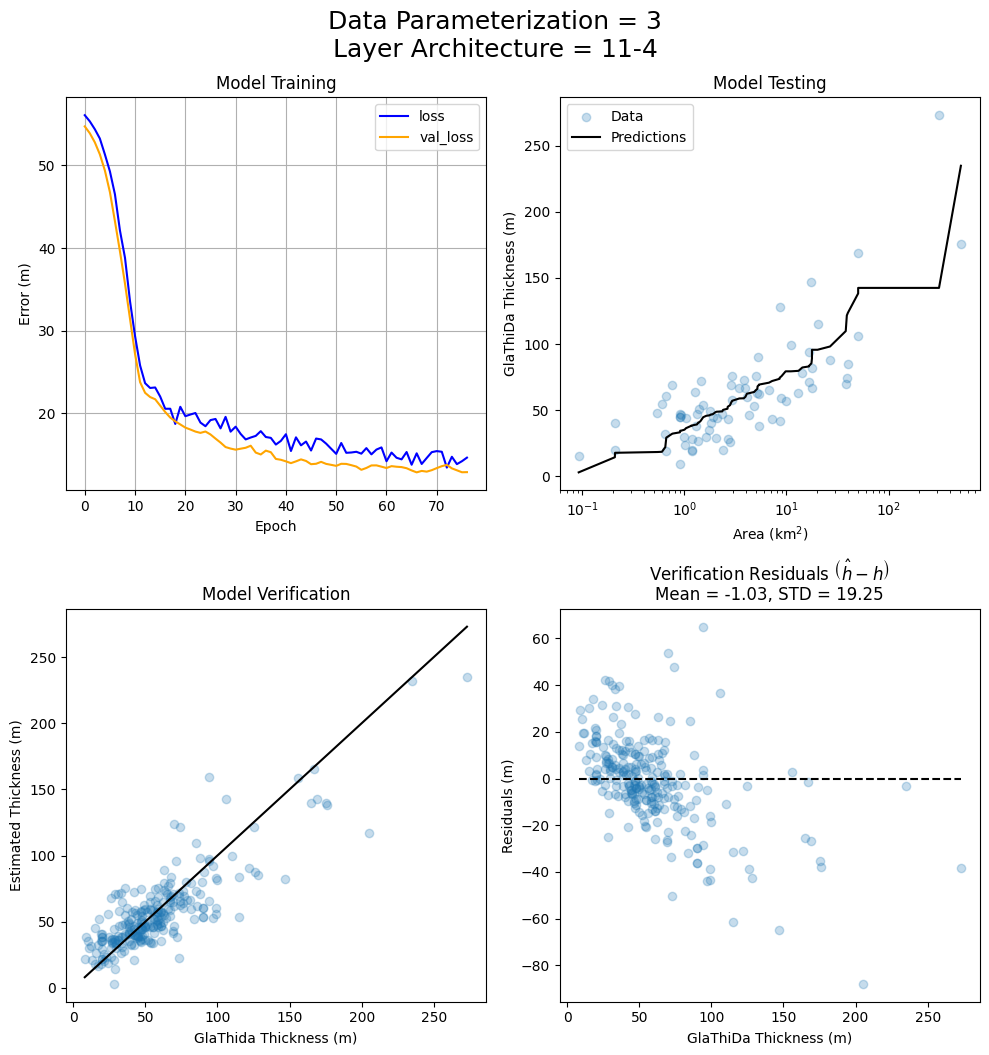

In [3]:
m = str(residuals['M'].iloc[residuals['MAE'].abs().argsort()[0]])
# m = '4'
df = gl.coregister_data(m)
# if m == '4':
#     df = df.drop_duplicates(keep = False)
#     df = df.drop(df[df['Thickness'] >= 300].index)
#     df = df.drop(df[df['Thickness'] == 267].index)
#     df = df.drop(df[df['Thickness'] == df['Thickness'].min()].index)
fig, ax = plt.subplots(2,2,figsize = (10,10))
ax[0][0].plot(
    model_history[m].history['loss'], 
     label='loss',
    color = 'blue'
)
ax[0][0].plot(
    model_history[m].history['val_loss'], 
    label='val_loss',
    color = 'orange'
)
#   plt.ylim([0, 10])
ax[0][0].set_xlabel('Epoch')
ax[0][0].set_ylabel('Error (m)')
ax[0][0].legend()
ax[0][0].grid(True)
ax[0][0].set_title('Model Training')


# y = model[m].predict(test_features).flatten()
ax[0][1].scatter(test_features[m]['Area'],test_labels[m],label = 'Data',alpha = 0.25)
#     ax[0][1].plot(
#         test_labels.sort_values(
#         ascending = True),test_labels.sort_values(
#         ascending = True),c = 'r',label = 'Data'
#     )
ax[0][1].plot(
    test_features[m]['Area'].sort_values(
    ascending = True),np.sort(y[m]),c = 'k',label = 'Predictions'
)
ax[0][1].set_xscale('log')
ax[0][1].set_title('Model Testing')
ax[0][1].set_xlabel('Area (km$^2$)')
ax[0][1].set_ylabel('GlaThiDa Thickness (m)')
ax[0][1].legend()



# y[p + str(m)] = model[m].predict(df.drop('Thickness',axis = 1)).flatten()   
# residuals = (y[test] - df['Thickness']) 
ax[1][1].scatter(df['Thickness'],y[str(1)+m],label = 'Data',alpha = 0.25)
ax[1][1].plot(
    (df['Thickness'].min(),df['Thickness'].max()),
    (0,0),
    c = 'k',
    linestyle = '--'
)
ax[1][1].set_title('Residuals')
ax[1][1].set_ylabel('Residuals (m)')
ax[1][1].set_xlabel('GlaThiDa Thickness (m)')
mean = np.round(np.mean(y[str(1) + str(m)]), 2)
std = np.round(np.std(y[str(1) + str(m)]), 2)
ax[1][1].set_title(
    r'Verification Residuals $\left(\hat{h} - h\right)$' + '\n' +
    f'Mean = {mean}, STD = {std}'
)
#     ax[1][1].legend()
#     plt.legend()
#     plt.show()



#     y = model[k].predict(df.drop('Thickness',axis = 1)).flatten()
ax[1][0].scatter(df['Thickness'],y[str(2) + (m)],label = 'Estimates',alpha = 0.25)
ax[1][0].plot(
    (df['Thickness'].min(),df['Thickness'].max()),
    (df['Thickness'].min(),df['Thickness'].max()),
    'k'
)
ax[1][0].set_title('Model Verification')
ax[1][0].set_xlabel('GlaThida Thickness (m)')
ax[1][0].set_ylabel('Estimated Thickness (m)')
plt.tight_layout()
fig.suptitle(
    'Data Parameterization = ' +  m + '\n' +
    'Layer Architecture = ' + str(l1[m]) + '-' + str(l2[m]),
    y = 1.05,
    fontsize = 18)


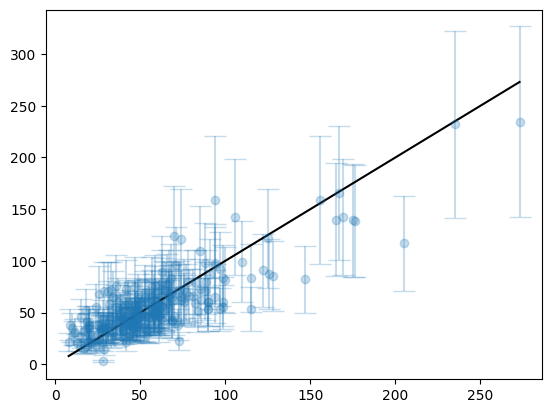

In [4]:
x = df['Thickness']
plt.errorbar(
    x,
    y[str(2) + m],
    yerr = unc[m],
    alpha = 0.25,
#     label = 'Estimates $\hat{\mu}(x)$',
    linestyle = 'None',
    marker = 'o',
    capsize = 8,
    color = '#1f77b4',
    label = 'Composite Thickness Estimate $\hat{\mu}$'
)
plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    c = 'k'
)

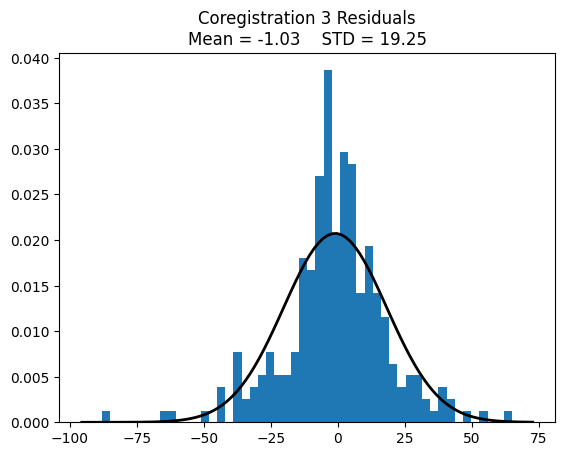

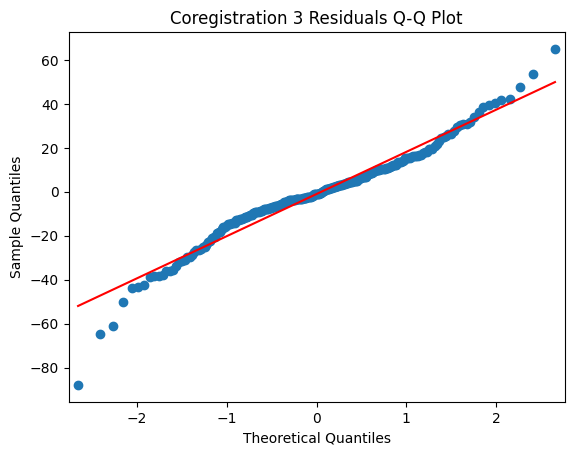

ShapiroResult(statistic=0.9626420140266418, pvalue=3.6034050481248414e-06)
KstestResult(statistic=0.4639296694834192, pvalue=1.383264316160586e-50, statistic_location=-2.2430038452148438, statistic_sign=1)


In [5]:
# y[str(1)+str(m)].sort_values().head(7)
t = pd.DataFrame(y[str(1)+str(m)])
# s = pd.Series(t)
mu, std = norm.fit(t) 
mu = np.round(mu, 2)
std = np.round(std, 2)
plt.hist(t, bins=50, density = True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)

plt.title(
    f'Coregistration {m} Residuals\n' + 
    f'Mean = {mu}    STD = {std}'
)
plt.show()
fig = sm.qqplot(t['Thickness'],line = 'r')

plt.title(f'Coregistration {m} Residuals Q-Q Plot')
plt.show()
# print(f'coregistration {m}')

print(shapiro(y[str(1) + str(m)]))
print(kstest(y[str(1) + str(m)], 'norm'))


### Residuals are not normally distributed

In [6]:
def load_data(i):
    j = str(i)
    estimates = pd.Series(y[str(2)+j],name = 'Estimates')
    df = gl.coregister_data(j)
    df = df.reset_index()
    df = df.drop('index', axis = 1)
    df = df.join(estimates)
    data = gl.load_notebook_data('4')
    data = data[['RGIId','FMT']]
    df = pd.merge(df,data,how = 'inner', on = 'RGIId')
    df = df.dropna(subset = ['FMT', 'Estimates'])
    print('df' + j + ' loaded')
    return df

In [7]:
df1 = load_data(1)
df2 = load_data(2)
df3 = load_data(3)
df4 = load_data(4)

df1 loaded
df2 loaded
df3 loaded
df4 loaded


Sorting data...
Calculating point density...
Sorting data...
Calculating point density...
Sorting data...
Calculating point density...
Sorting data...
Calculating point density...


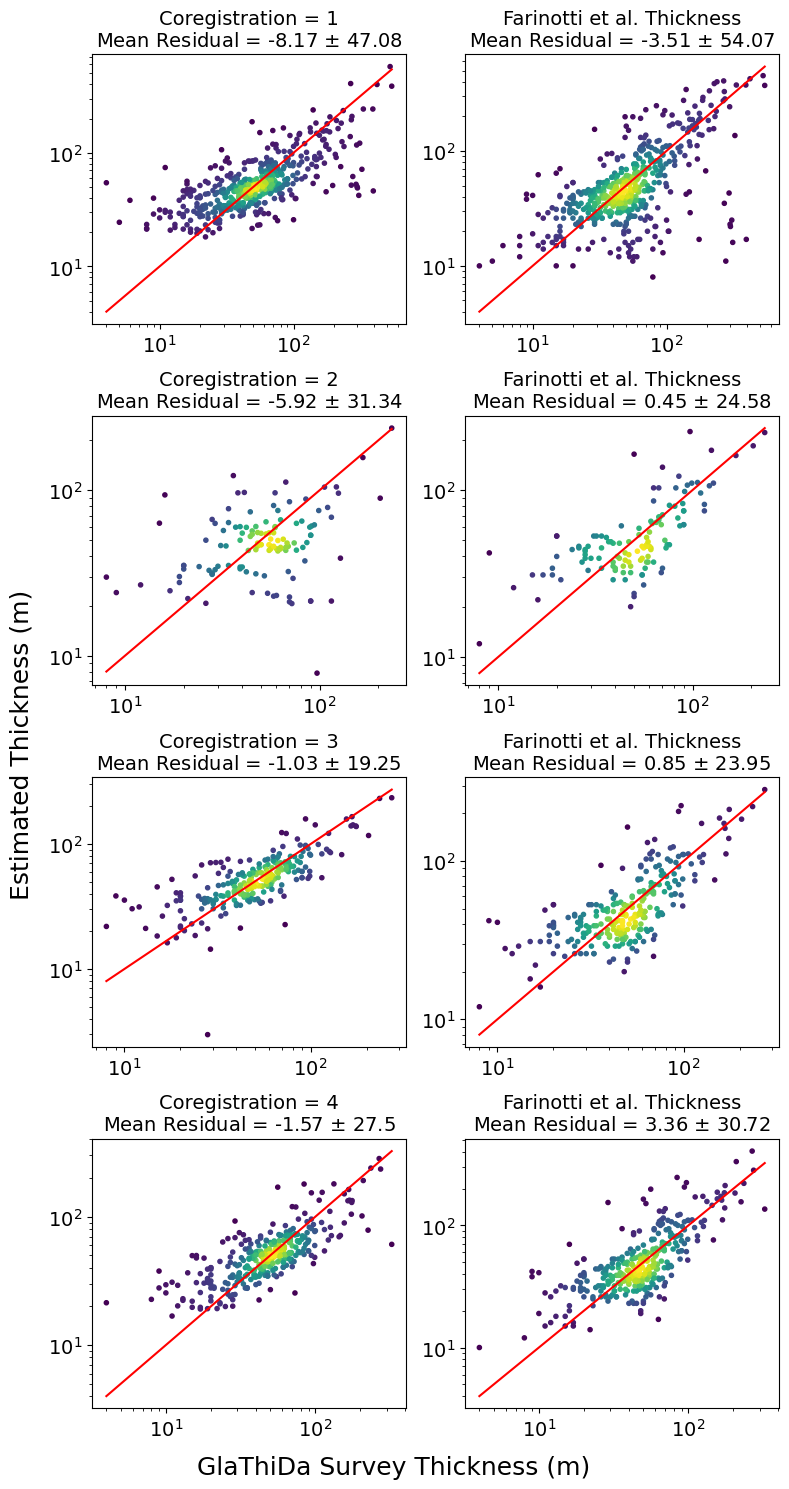

In [8]:
fig, ax = plt.subplots(4,2,figsize = (8,15),
#                        sharex = True, sharey = True
                      )

for n, dataset in enumerate((df1, df2,
                             df3, df4
                            )):
    data = dataset
    if n == 0:
        threshold = 'No Threshold'
    if n == 1:
        threshold = '0.25'
    if n == 2:
        threshold = '0.50'
    if n == 3:
        threshold = '0.75'
#     axs = plt.subplot(4, 1, n+1)
#     print(data)
    data_1 = data['Estimates']
    data_2 = data['FMT']
    data_3 = data['Thickness']

    data_4 = data['Estimates'] - data['Thickness']
    data_5 = data['FMT'] - data['Thickness']
    
    res = np.round(np.mean(data_4),2)
    std = np.round(np.std(data_4),2)
    fres = np.round(np.mean(data_5),2)
    fstd = np.round(np.std(data_5),2)
    # data_1 = ref['Farinotti Mean Thickness'] / 1e3 * ref['Area']
    # data_2 = ref['Edasi Mean Thickness'] / 1e3 * ref['Area']

    print('Sorting data...')
    x_1 = np.sort(data_1)
    y_1 = 1. * np.arange(len(data_1)) / (len(data_1) - 1)

    x_2 = np.sort(data_2)
    y_2 = 1. * np.arange(len(data_2)) / (len(data_2) - 1)

    x_3 = np.sort(data_3)
    y_3 = 1. * np.arange(len(data_3)) / (len(data_3) - 1)

    print('Calculating point density...')
    # Calculate the point density
    xy = np.vstack([np.log10(data_1),np.log10(data_3)])

    z_1 = gaussian_kde(xy)(xy)

    yz = np.vstack([np.log10(data_2),np.log10(data_3)])

    z_2 = gaussian_kde(yz)(yz)
    
    ax[n,0].scatter(
            data_3,
            data_1,
            c = z_1,
            cmap = 'viridis',
            marker = '.'
        )
    ax[n,0].set_xscale('log')
    ax[n,0].set_yscale('log')
    ax[n,0].plot(
        (data['Thickness'].min(), data['Thickness'].max()),
        (data['Thickness'].min(), data['Thickness'].max()),
        color = 'red',
        linestyle = '-'
    )
    
#     ax[n,0].set_xlabel('GlaThiDa Survey Thickness (m)')
#     ax[n,0].set_ylabel('Estimated Thickness (m)')
    ax[n,0].set_title('Coregistration = ' + str(n+1) + '\n'+
                      f'Mean Residual = {res} $\pm$ {std}',
                     fontsize = 14)
    
    ax[n,1].scatter(
            data_3,
            data_2,
            c = z_2,
            cmap = 'viridis',
            marker = '.'
        )
    ax[n,1].plot(
        (data['Thickness'].min(), data['Thickness'].max()),
        (data['Thickness'].min(), data['Thickness'].max()),
        color = 'red',
        linestyle = '-'
    )
    ax[n,1].set_xscale('log')
    ax[n,1].set_yscale('log')
    ax[n,1].set_title('Farinotti et al. Thickness\n'+
                       f'Mean Residual = {fres} $\pm$ {fstd}',
                     fontsize = 14)
    ax[n,0].tick_params(axis="both", labelsize=14)
    ax[n,1].tick_params(axis="both", labelsize=14)
#     ax[n,1].set_xlabel('GlaThiDa Survey Thickness (m)')
#     ax[n,1].set_ylabel('Farinotti Estimated Thickness (m)')
#     ax[n,1].set_title('Farinotti et al. 2019')
    
# plt.suptitle('Comparison of Non-Ice Sheet Glacier Thickness Estimates', y = 0.99)
fig.supylabel('Estimated Thickness (m)', fontsize = 18)
fig.supxlabel('GlaThiDa Survey Thickness (m)', fontsize = 18)

plt.tight_layout()

In [9]:
print('Select coregistration number')
sc = str(input())

Select coregistration number
4


In [10]:
RGI = gl.load_RGI()

rfp = RGI[list(df.drop('Thickness', axis = 1))]
# rfp['Area'] = np.log(rfp['Area'])
y = pd.Series(model[sc].predict(rfp.drop('RGIId',axis = 1)).flatten(), name = 'Thickness')

rfp = rfp.join(y)
rfp['unc'] = (gamma[str(3) + m] * rfp['Thickness'])**2

vol = rfp['Area'] * (rfp['Thickness'] / 1e3)
vol_unc = rfp['Area'] * (np.sqrt(rfp['unc'] )/ 1e3)

sum_vol = sum(vol)
sum_vol_unc = np.sqrt(sum(vol_unc**2))

print(sum_vol / 1e3)
print(sum_vol_unc / 1e3)

6766/6766 [==============================] - 4s 637us/step
152.5051647828473
4.269001995878534


In [11]:
data = gl.load_notebook_data('4')
data = data[['RGIId','FMT','region']]
rfp = pd.merge(rfp, data, how = 'inner',on = 'RGIId')
rfp = rfp.dropna(subset = ['FMT'])


In [12]:
x = rfp['Area'] * (rfp['FMT'] / 1e3)
y = rfp['Area'] * (rfp['Thickness'] / 1e3)
xy = np.vstack([np.log10(x),np.log10(y)])
# z = gaussian_kde(xy)(xy)

In [13]:
bins_x = np.logspace(np.log10(np.min(x)), np.log10(np.max(x)), 25)
bins_y = np.logspace(np.log10(np.min(y)), np.log10(np.max(y)), 25)

Drawing scatter plot...
Drawing done
Setting scales and labels...


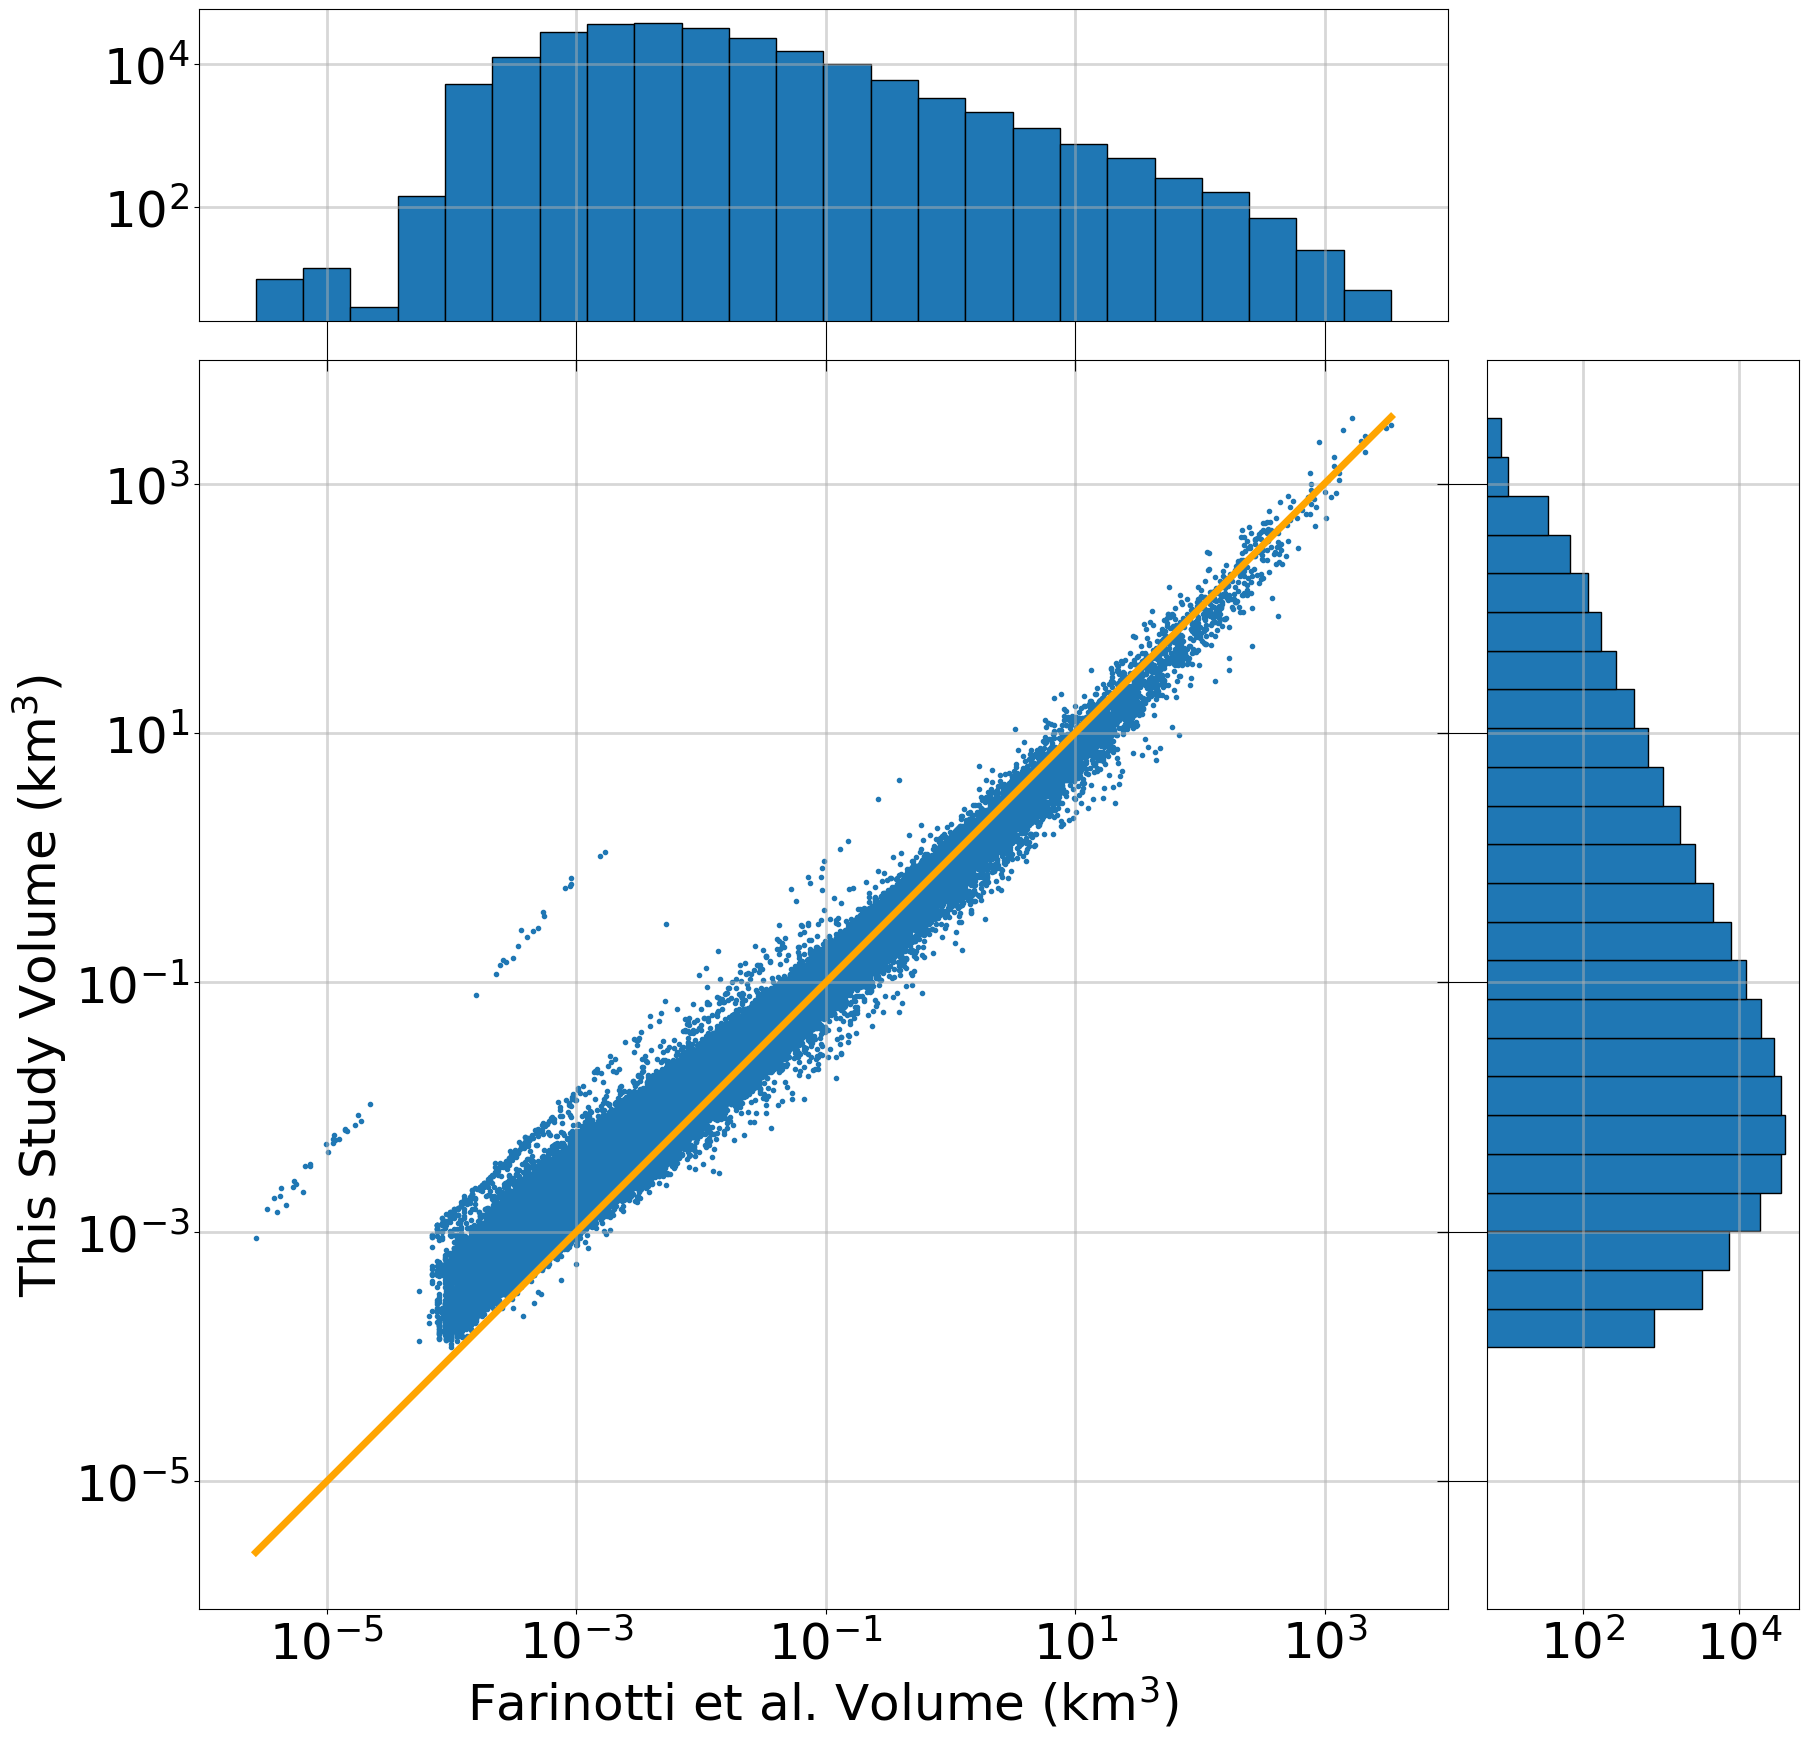

In [14]:
def scatter_hist(x, y, ax, 
                 ax_histx, ax_histy
                ):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False, size = 36)
    ax_histy.tick_params(axis="y", labelleft=False, size = 36)

    # the scatter plot:
    ax.scatter(x, y, 
#                c = (z), 
#                s = 100,
#                cmap = 'viridis',
               marker = '.'
              )
    ax.plot(
        (x.min(),x.max()),
        (x.min(),x.max()),
        '-',
        c = 'orange',
        linewidth = 5

    )

    ax_histx.hist(
        (x), 
        bins = bins_x,
        edgecolor = 'black',
        log = True
    )

    ax_histy.hist(
        (y), 
        bins = bins_y, 
        edgecolor = 'black',
        orientation='horizontal',
        log = True
    )
    ax_histx.tick_params(axis="x", labelsize=36)
    ax_histy.tick_params(axis="y", labelsize=36)
    ax_histy.grid(alpha = 0.5,linewidth = 2)
    ax_histx.grid(alpha = 0.5,linewidth = 2)

fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)


# Create the Axes.

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex = ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey = ax)


ax_histx.tick_params(axis="y", labelsize=36)
ax_histy.tick_params(axis="x",which = 'major', labelsize=36)

ax.tick_params(axis="both", labelsize=36)
ax.tick_params(which='minor', color='r', labelsize = 36)


print('Drawing scatter plot...')
scatter_hist(
    x, 
    y,
    ax, 
    ax_histx,
    ax_histy,
)
print('Drawing done')
print('Setting scales and labels...')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('This Study Volume (km$^3$)', fontsize = 36)
ax.set_xlabel('Farinotti et al. Volume (km$^3$)', fontsize = 36)
ax.grid(which = 'major',alpha = 0.5,linewidth = 2)
ax.grid(which = 'minor',alpha = 0.5,linewidth = 1,linestyle = '--')
# plt.text(1e-16, 300000, 'A.',fontsize = 42)
# plt.text(1e-16, 3500, 'C.',fontsize = 42)
# plt.text(10, 3500, 'B.',fontsize = 42)

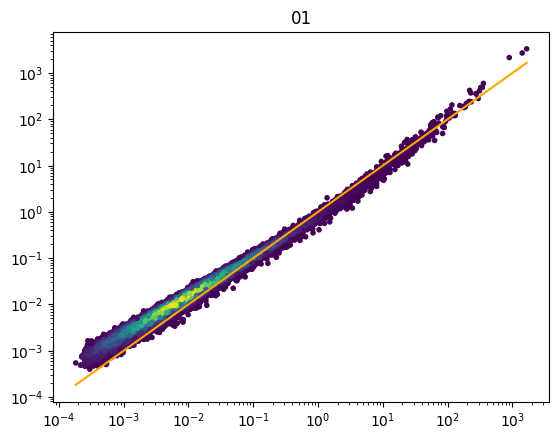

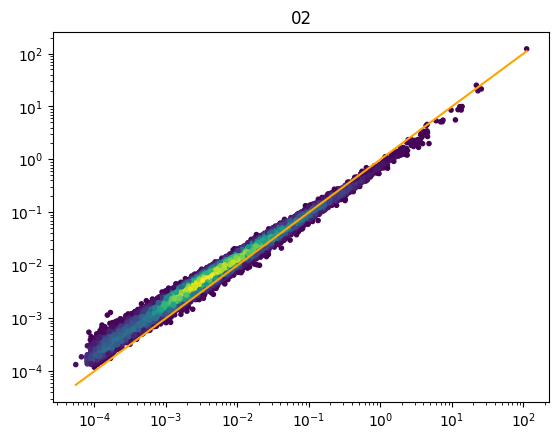

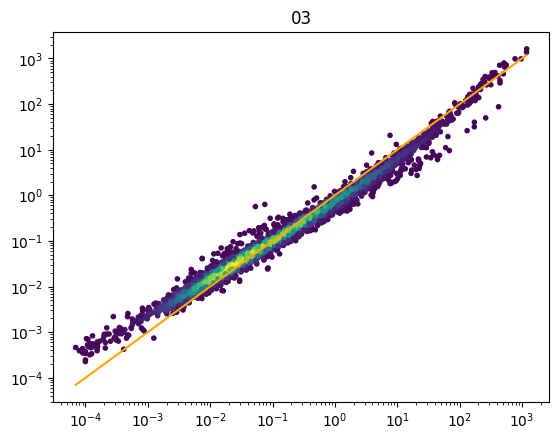

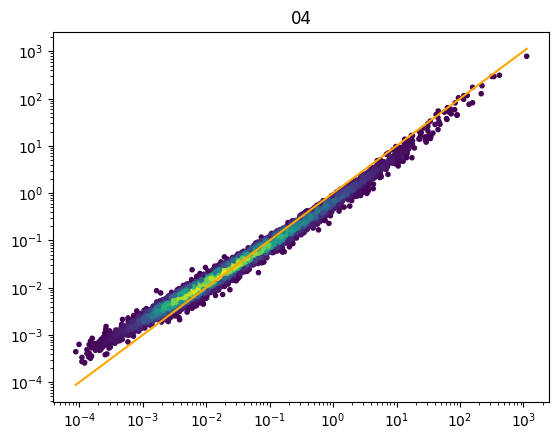

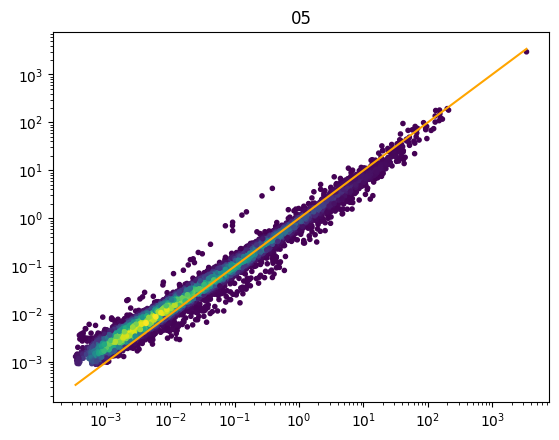

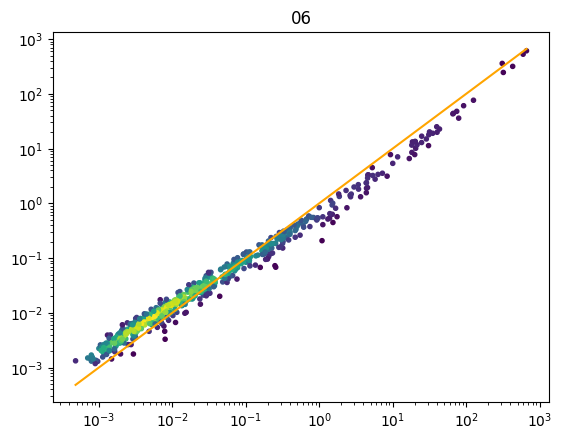

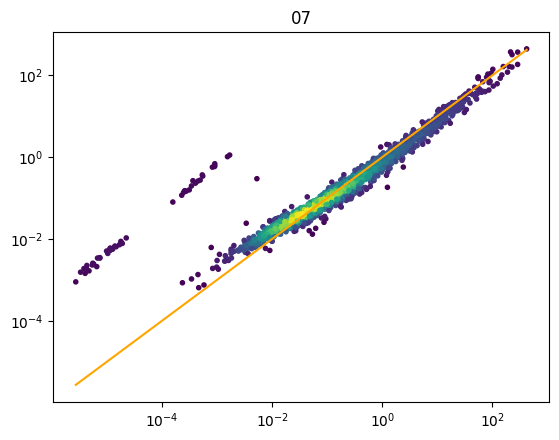

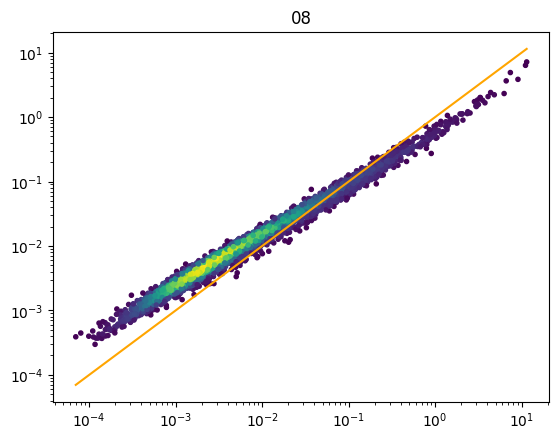

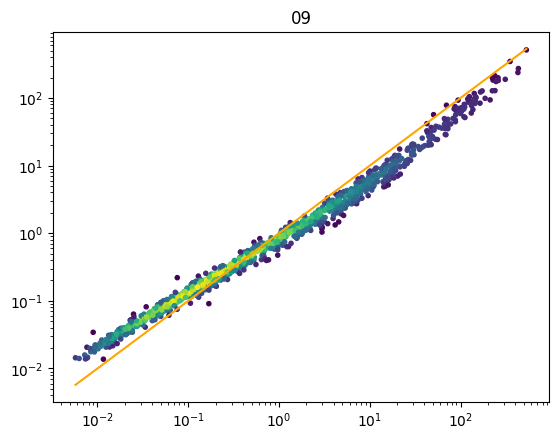

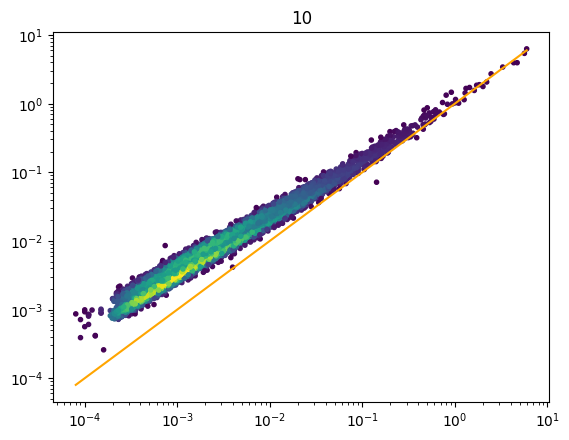

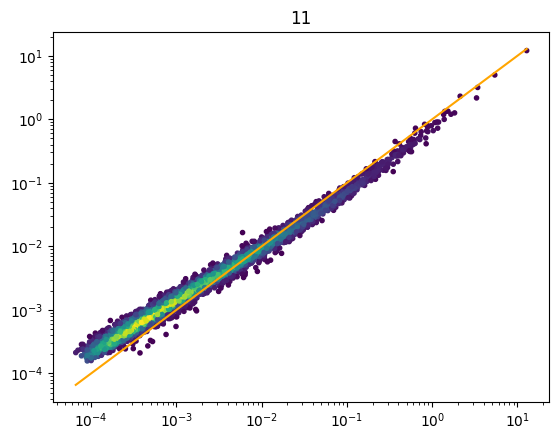

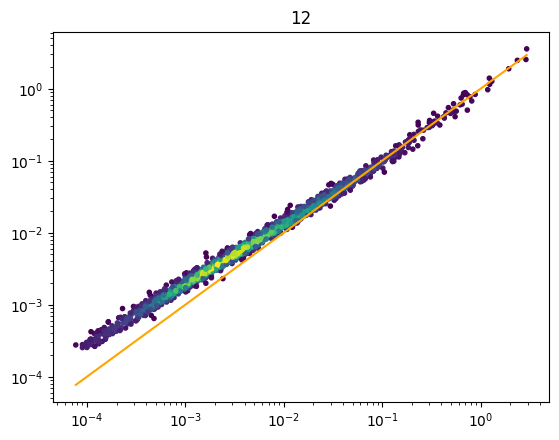

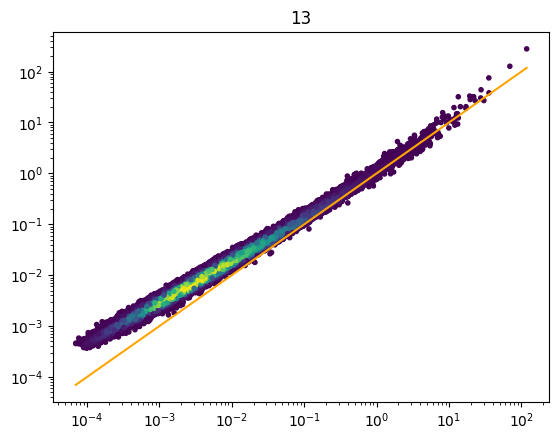

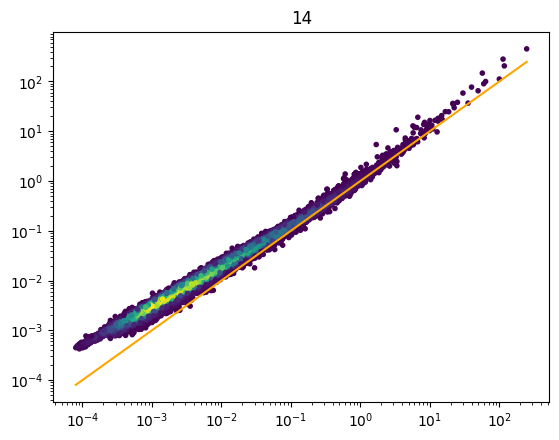

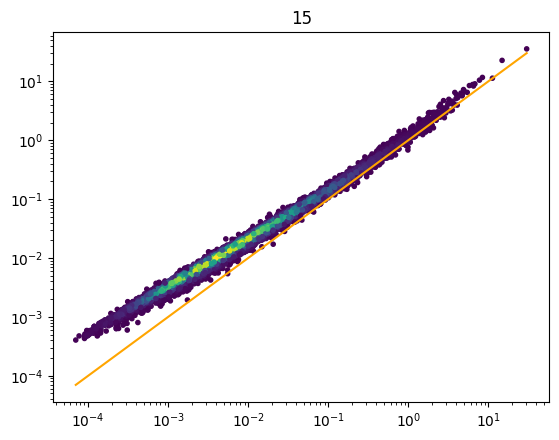

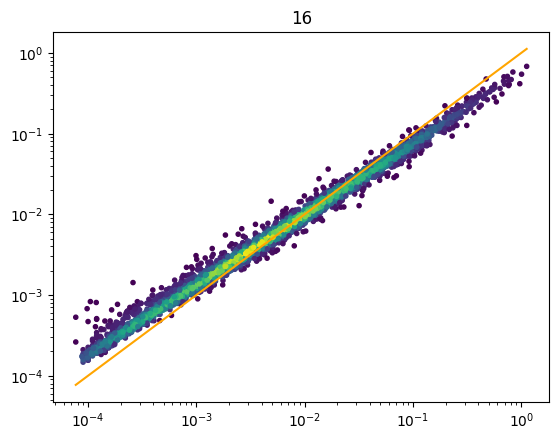

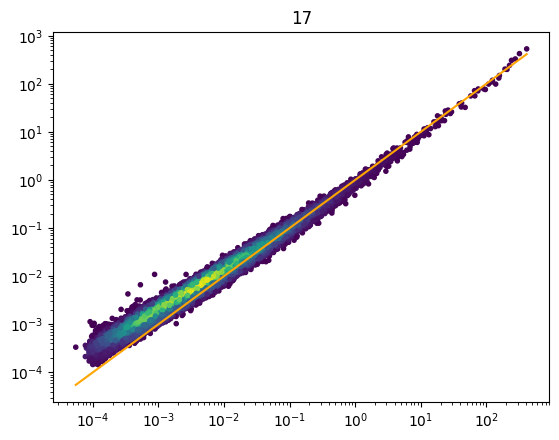

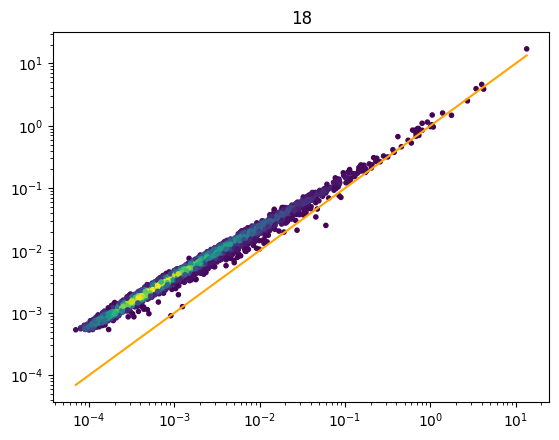

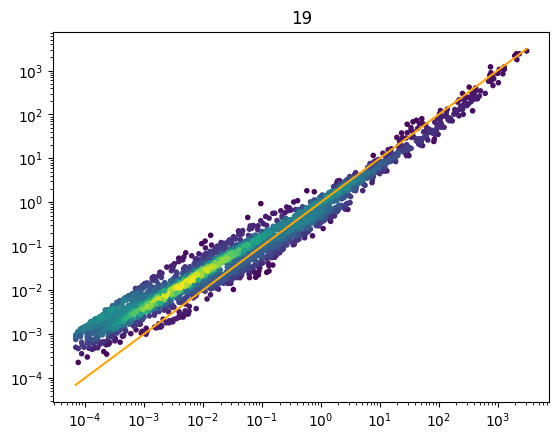

In [15]:
for region in rfp['region'].unique():
    dft = rfp[rfp['region'] == region]
    x = dft['Area'] * (dft['FMT'] / 1e3)
    y = dft['Area'] * (dft['Thickness'] / 1e3)
    xy = np.vstack([np.log10(x),np.log10(y)])
    z = gaussian_kde(xy)(xy)
    plt.scatter(
        x,y,
        c = z,cmap = 'viridis',
        marker = '.'
    )
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(
        (x.min(),x.max()),
        (x.min(),x.max()),
        c = 'orange'
    )
    plt.title(region)
    plt.show()
    